# 데이터 로드 및 병합

* train 파일과 test 파일들을 각각 병합한다.

In [2]:
import pandas as pd
import os
import glob

# ==========================================
# 1. 환경 설정
# ==========================================
# 사용자의 로컬 경로 (Raw 문자열 r'' 사용 추천)
BASE_PATH = r'C:\Users\CY2\github\DataScience\Credit Card'

# 데이터 타입
DATA_TYPES = ['train', 'test']

# 병합할 월 리스트
MONTHS = ['201807', '201808', '201809', '201810', '201811', '201812']

# 처리할 데이터 번호 및 키워드 (순서 중요: 1번이 기준 데이터)
# (번호, 내용) - 내용은 로그 출력용
TARGET_INFO = [
    (1, "회원"),
    (2, "신용"),
    (3, "승인매출"),
    (4, "청구"),
    (5, "잔액"),
    (6, "채널"),
    (7, "마케팅"),
    (8, "성과")
]

# ==========================================
# 2. 스마트 경로 탐색 및 로드 함수
# ==========================================
def find_and_read_parquet(base_dir, data_type, file_idx, month):
    """
    특정 번호(file_idx)로 시작하는 폴더를 찾아, 
    그 안에서 해당 월(month)과 타입(data_type)이 포함된 parquet 파일을 엽니다.
    """
    # 1. 해당 타입 폴더 경로 (예: .../Credit Card/test)
    type_dir = os.path.join(base_dir, data_type)
    
    if not os.path.exists(type_dir):
        return None, f"폴더 없음: {type_dir}"

    # 2. 해당 번호로 시작하는 하위 폴더 찾기 (예: '1.회원정보' 찾기)
    # 폴더 목록 중 '1.' 또는 '1_' 등으로 시작하는 폴더 검색
    try:
        sub_dirs = [d for d in os.listdir(type_dir) if os.path.isdir(os.path.join(type_dir, d))]
        target_folder = None
        for d in sub_dirs:
            if d.startswith(f"{file_idx}.") or d.startswith(f"{file_idx}_"):
                target_folder = d
                break
        
        if not target_folder:
            return None, f"폴더 못 찾음: {file_idx}번 폴더"

        # 3. 폴더 내에서 파일 찾기
        target_dir = os.path.join(type_dir, target_folder)
        # 파일명 패턴: 해당 월(201807)과 타입(test)이 포함된 .parquet 파일
        search_pattern = os.path.join(target_dir, f"*{month}*{data_type}*.parquet")
        files = glob.glob(search_pattern)
        
        if not files:
            return None, f"파일 없음: {target_folder} 내 {month} 파일"
        
        # 첫 번째로 검색된 파일 읽기
        file_path = files[0]
        df = pd.read_parquet(file_path)
        return df, f"성공 ({os.path.basename(file_path)})"

    except Exception as e:
        return None, f"에러 발생: {e}"

# ==========================================
# 3. 전체 병합 실행 로직
# ==========================================
print(f"📂 작업 경로: {BASE_PATH}")

for dtype in DATA_TYPES:
    print(f"\n🚀 [{dtype.upper()}] 데이터 통합 시작...")
    all_monthly_dfs = []
    
    for month in MONTHS:
        print(f"   📅 {month} 처리 중...")
        
        # 1) 기준(Base) 데이터 로드 - 1.회원정보
        df_base, msg = find_and_read_parquet(BASE_PATH, dtype, 1, month)
        
        if df_base is None:
            print(f"      [SKIP] 기준 데이터 로드 실패: {msg}")
            continue
            
        print(f"      - 기준(회원): {msg} - Shape: {df_base.shape}")
        
        # 2) 나머지 데이터(2~8번) 순차 병합
        for idx, desc in TARGET_INFO[1:]:
            df_target, msg = find_and_read_parquet(BASE_PATH, dtype, idx, month)
            
            if df_target is not None:
                # 공통 컬럼 자동 탐색 (ID 등)
                common_cols = list(set(df_base.columns) & set(df_target.columns))
                
                # 병합 (Left Join)
                df_base = pd.merge(df_base, df_target, on=common_cols, how='left')
                print(f"      + 병합({desc}): {msg} -> Current Shape: {df_base.shape}")
            else:
                print(f"      [PASS] {desc}: {msg}")
        
        # 월별 병합 결과 리스트에 추가
        all_monthly_dfs.append(df_base)

    # 최종 저장
    if all_monthly_dfs:
        print("   ----------------------------------------")
        print("   🔨 월별 데이터 수직 결합 중...")
        final_df = pd.concat(all_monthly_dfs, ignore_index=True)
        
        save_name = os.path.join(BASE_PATH, f"merged_{dtype}.parquet")
        final_df.to_parquet(save_name)
        
        print(f"✅ [{dtype.upper()}] 최종 저장 완료!")
        print(f"   💾 파일명: {save_name}")
        print(f"   📊 총 데이터 크기: {final_df.shape}")
    else:
        print(f"⚠️ [{dtype.upper()}] 병합된 데이터가 없습니다.")

print("\n모든 작업 완료.")

📂 작업 경로: C:\Users\CY2\github\DataScience\Credit Card

🚀 [TRAIN] 데이터 통합 시작...
   📅 201807 처리 중...
      - 기준(회원): 성공 (201807_train_회원정보.parquet) - Shape: (400000, 78)
      + 병합(신용): 성공 (201807_train_신용정보.parquet) -> Current Shape: (400000, 118)
      + 병합(승인매출): 성공 (201807_train_승인매출정보.parquet) -> Current Shape: (400000, 522)
      + 병합(청구): 성공 (201807_train_청구정보.parquet) -> Current Shape: (400000, 566)
      + 병합(잔액): 성공 (201807_train_잔액정보.parquet) -> Current Shape: (400000, 646)
      + 병합(채널): 성공 (201807_train_채널정보.parquet) -> Current Shape: (400000, 749)
      + 병합(마케팅): 성공 (201807_train_마케팅정보.parquet) -> Current Shape: (400000, 811)
      + 병합(성과): 성공 (201807_train_성과정보.parquet) -> Current Shape: (400000, 858)
   📅 201808 처리 중...
      - 기준(회원): 성공 (201808_train_회원정보.parquet) - Shape: (400000, 78)
      + 병합(신용): 성공 (201808_train_신용정보.parquet) -> Current Shape: (400000, 118)
      + 병합(승인매출): 성공 (201808_train_승인매출정보.parquet) -> Current Shape: (400000, 522)
      + 병합(청구): 성공 (2018

# EDA

### 나라면 어떤 정보들을 기준으로 분류할까?

* 1. 리스크 관리
    * 5.잔액정보 - 연체작앤 , 잔액_리볼빙 , 총 잔액
    * 2.신용정보 - 한도금액
* 2. 수익성
    * 3.승인매출정보 - 이용금액_할부 , 이용금액_카드론/CA
    * 1.회원정보 - 소지카드수
* 3. 활동성
    * 8.성과정보 - 증감율_이용금액_전월
    * 4.청구입금정보 - 청구서발송여부

In [11]:
import pyarrow.parquet as pq
import pandas as pd
import os

# 파일 경로 설정
file_path = r'C:\Users\CY2\github\DataScience\Credit Card\merged_train.parquet'

if os.path.exists(file_path):
    print("✅ 파일 연결 성공! (메모리 안전 모드)")
    
    # 1. Parquet 파일 연결
    parquet_file = pq.ParquetFile(file_path)
    
    # 2. 전체 데이터 형태 확인
    print(f"총 행 수 (Rows): {parquet_file.metadata.num_rows:,} 개")
    print(f"총 컬럼 수 (Columns): {parquet_file.metadata.num_columns} 개")
    
    print("\n" + "="*50)
    print("📊 [Column Info] 컬럼명 및 데이터 타입 확인")
    print("="*50)
    
    # 3. 껍데기(Schema)만 읽어서 info 처럼 보여주기
    # 전체를 다 읽으면 메모리가 터지므로, 스키마 정보를 활용합니다.
    schema = parquet_file.schema
    
    for i, name in enumerate(schema.names):
        # 보기 좋게 10개씩 끊어서 출력하거나, 중요 컬럼 위주로 볼 수 있습니다.
        # 여기서는 앞부분 20개만 예시로 출력합니다.
        if i < 20: 
            # Parquet의 타입 정보를 출력
            print(f"{i+1}. {name} \t({schema.column(i).physical_type})")
            
    if len(schema.names) > 20:
        print(f"... 외 {len(schema.names) - 20}개 컬럼 생략 ...")

    print("\n" + "="*50)
    print("🧪 [Sample Info] 실제 데이터 1,000개로 확인한 Pandas Info")
    print("="*50)
    
    # 4. 실제 Pandas 스타일의 info() (샘플 1000개만 사용)
    # Dtype(object, int, float)을 정확히 파악하기 좋습니다.
    sample_df = next(parquet_file.iter_batches(batch_size=1000)).to_pandas()
    sample_df.info()

else:
    print("❌ 파일을 찾을 수 없습니다.")

✅ 파일 연결 성공! (메모리 안전 모드)
총 행 수 (Rows): 2,400,000 개
총 컬럼 수 (Columns): 858 개

📊 [Column Info] 컬럼명 및 데이터 타입 확인
1. 기준년월 	(INT64)
2. ID 	(BYTE_ARRAY)
3. 남녀구분코드 	(INT64)
4. 연령 	(BYTE_ARRAY)
5. Segment 	(BYTE_ARRAY)
6. 회원여부_이용가능 	(INT64)
7. 회원여부_이용가능_CA 	(INT64)
8. 회원여부_이용가능_카드론 	(INT64)
9. 소지여부_신용 	(INT64)
10. 소지카드수_유효_신용 	(INT64)
11. 소지카드수_이용가능_신용 	(INT64)
12. 입회일자_신용 	(INT64)
13. 입회경과개월수_신용 	(INT64)
14. 회원여부_연체 	(INT64)
15. 이용거절여부_카드론 	(INT64)
16. 동의여부_한도증액안내 	(INT64)
17. 수신거부여부_TM 	(INT64)
18. 수신거부여부_DM 	(INT64)
19. 수신거부여부_메일 	(INT64)
20. 수신거부여부_SMS 	(INT64)
... 외 838개 컬럼 생략 ...

🧪 [Sample Info] 실제 데이터 1,000개로 확인한 Pandas Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 858 entries, 기준년월 to 혜택수혜율_B0M
dtypes: float64(61), int64(747), object(50)
memory usage: 6.5+ MB


### info를 보고 느낀점

* Segment가 BYTE_ARRAY이므로 변환 필요함 = 숫자로 변환
* object 컬럼이 50개나 되므로 이부분 전처리 필요함 = 삭제 or 숫자로 변환
* folat값도 결측치가 포함된 컬럼임을 암시함 = NaN값 처리 필요

🕵️‍♂️ 전체 이상치 탐색 시작...

🚨 총 56개의 이상치 의심 컬럼을 발견했습니다!
그래프를 생성합니다... (20개씩 끊어서 출력)

📄 Page 1 / 3 (컬럼 1~20)


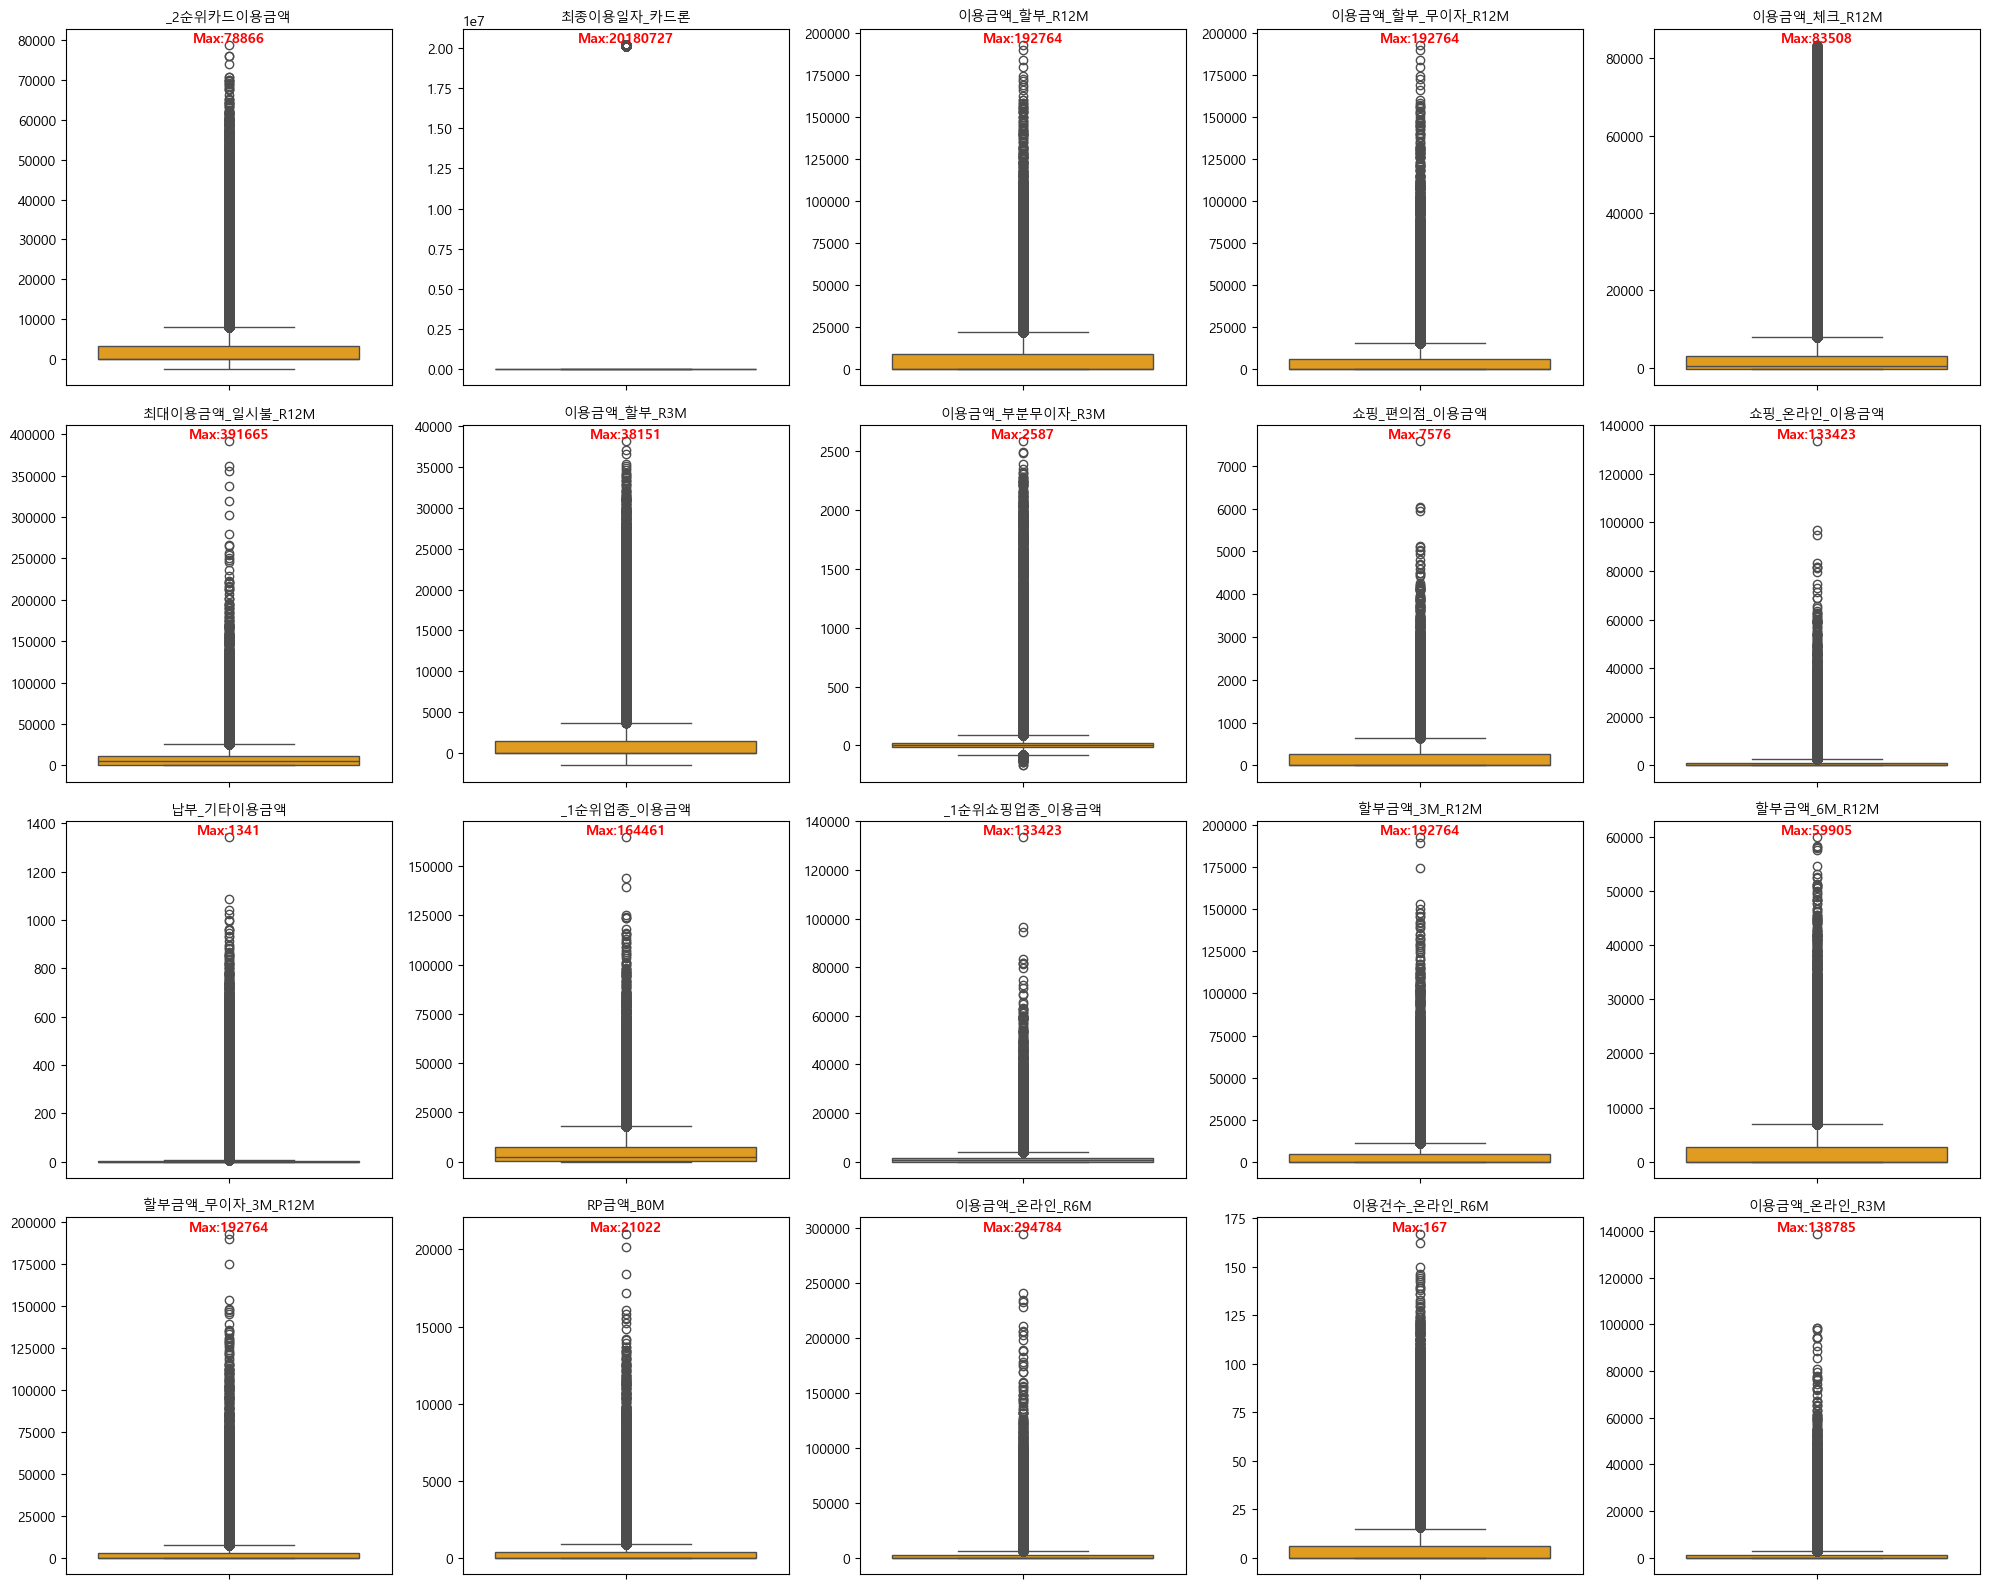


📄 Page 2 / 3 (컬럼 21~40)


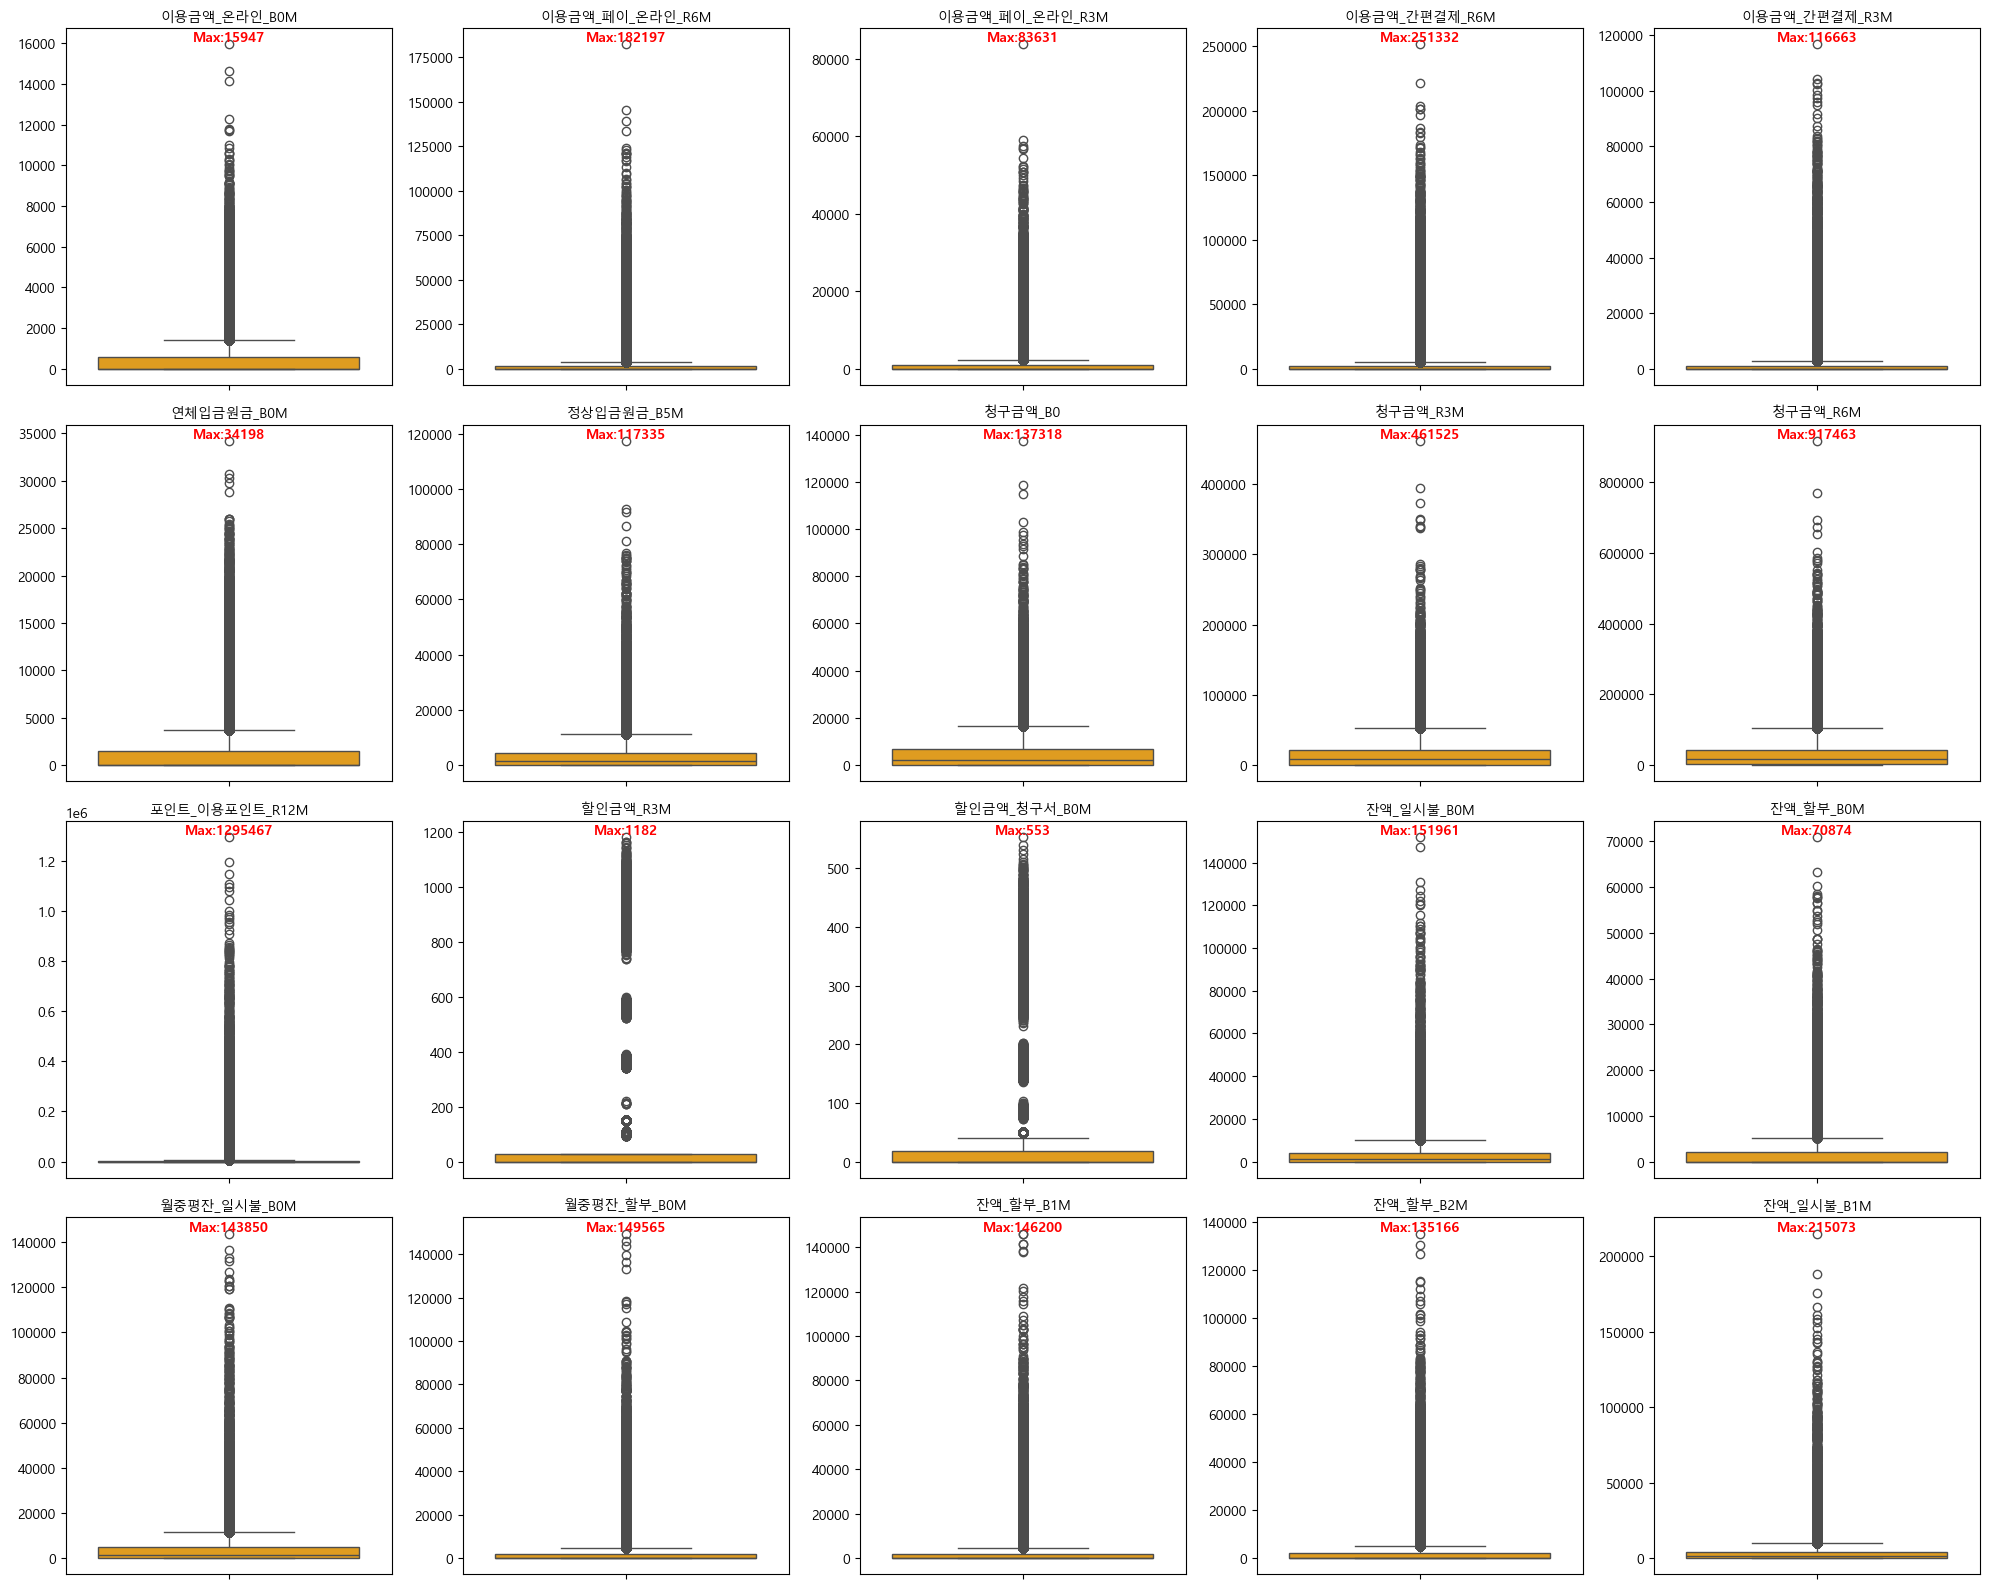


📄 Page 3 / 3 (컬럼 41~56)


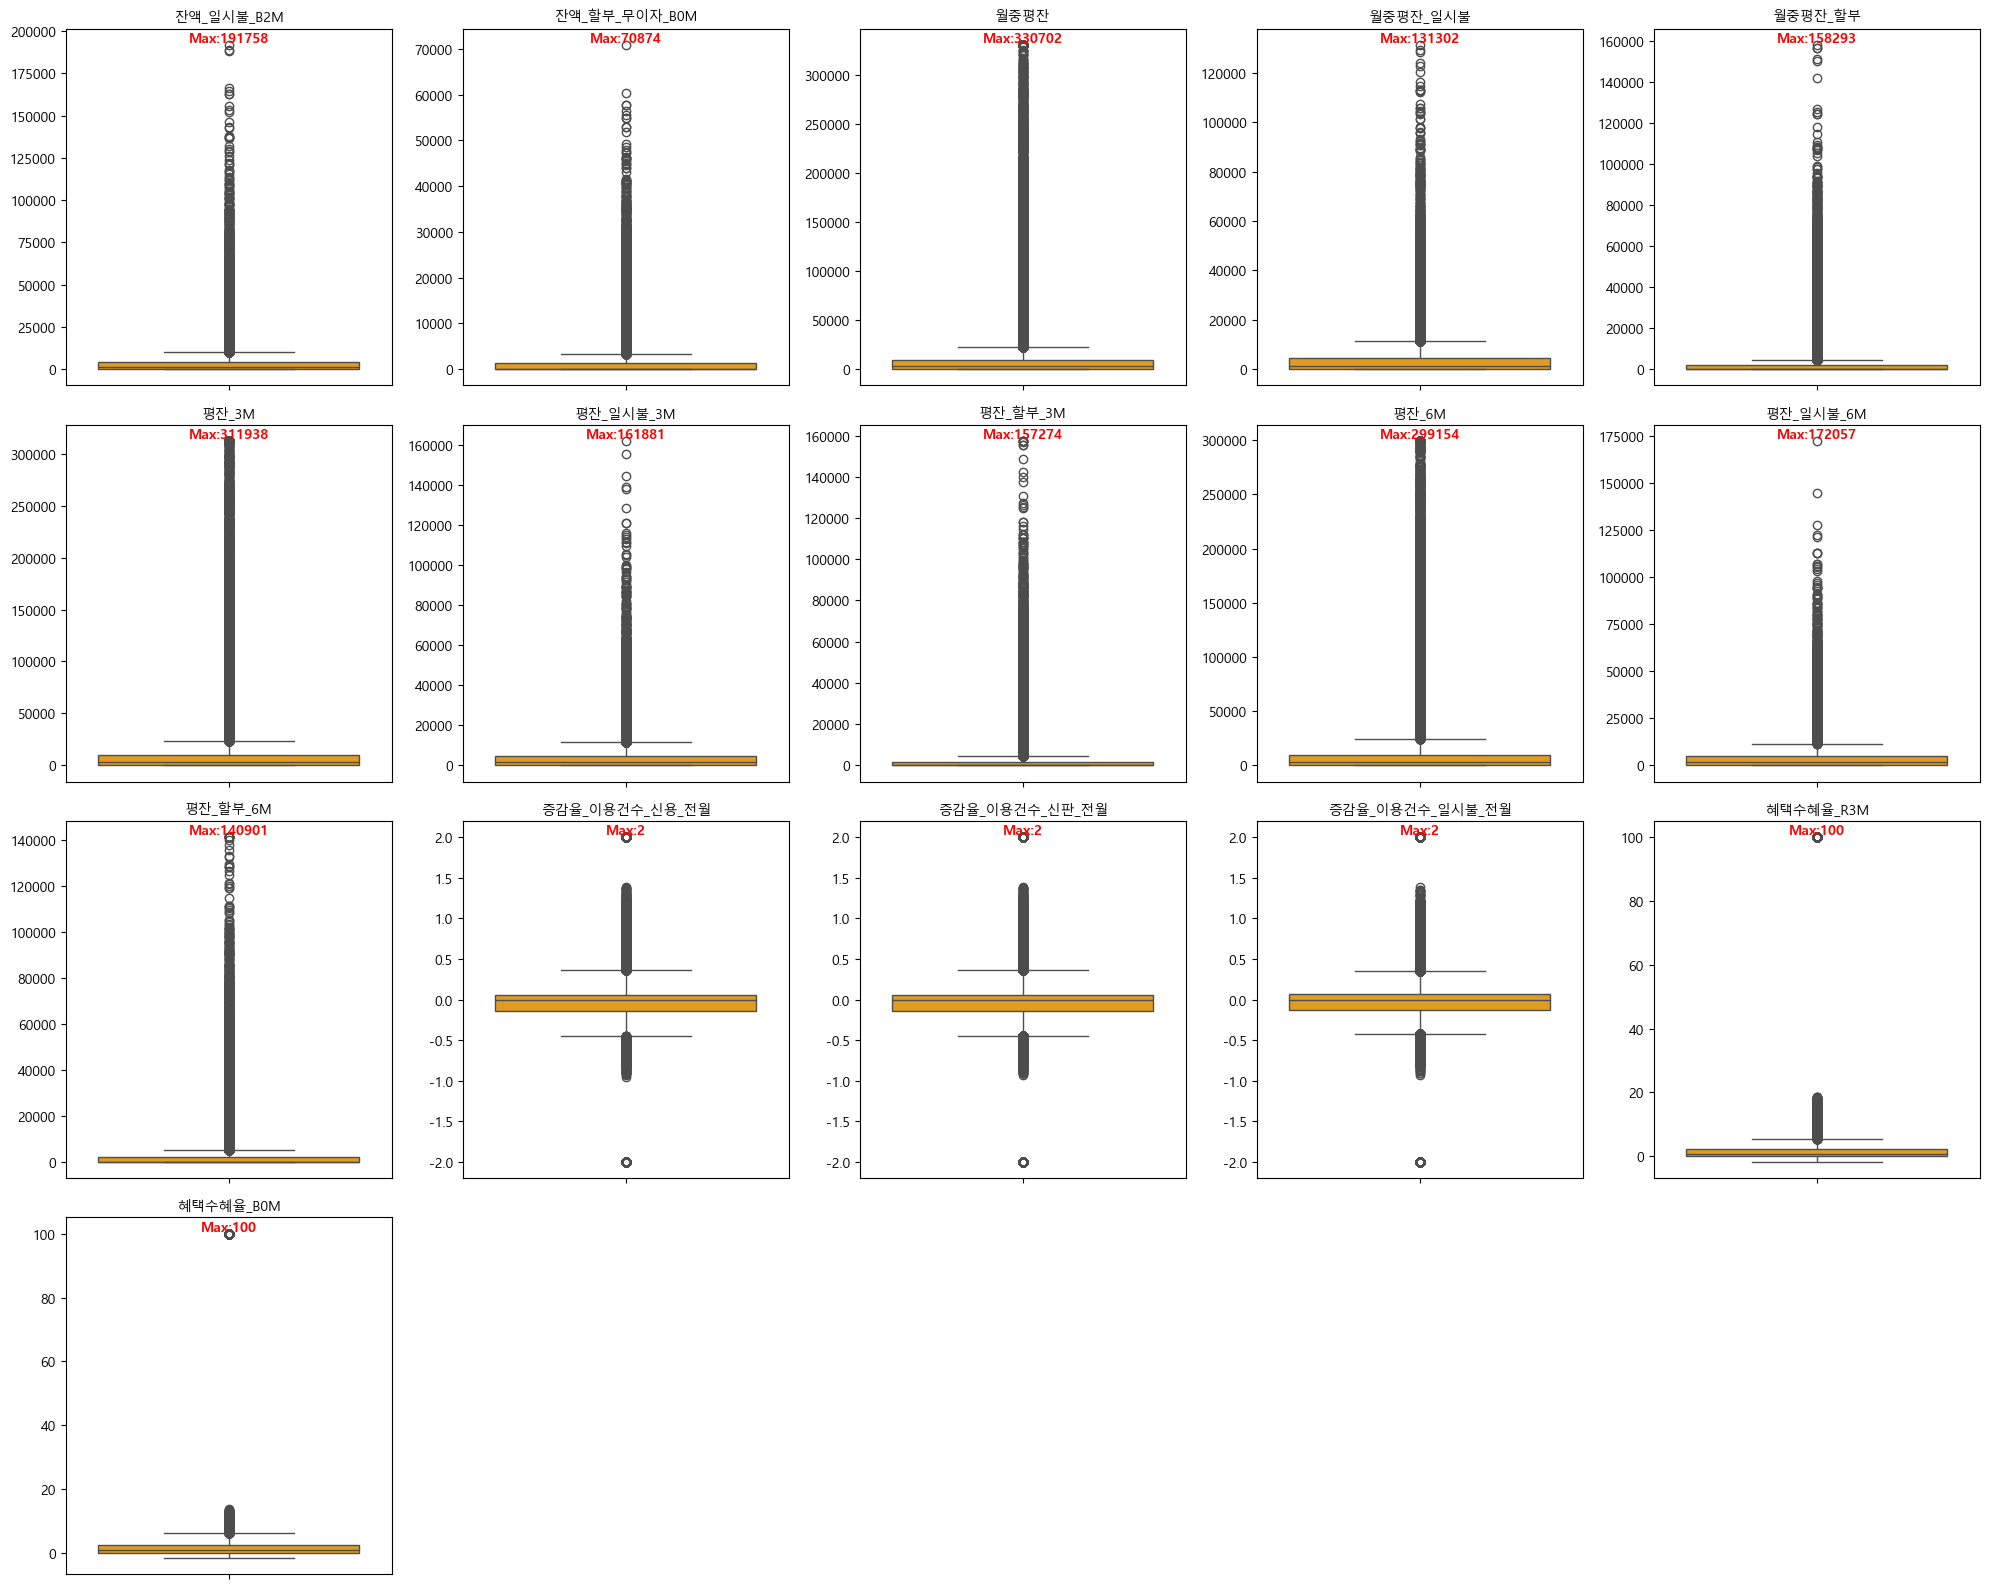

In [13]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# ==========================================
# 1. 설정 및 데이터 로드 (샘플링)
# ==========================================
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

file_path = r'C:\Users\CY2\github\DataScience\Credit Card\merged_train.parquet'
SAMPLE_SIZE = 100000

if os.path.exists(file_path):
    print("🕵️‍♂️ 전체 이상치 탐색 시작...")
    
    parquet_file = pq.ParquetFile(file_path)
    df = next(parquet_file.iter_batches(batch_size=SAMPLE_SIZE)).to_pandas()
    
    # ==========================================
    # 2. 이상치 컬럼 자동 적발
    # ==========================================
    suspicious_cols = []
    num_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in num_cols:
        if df[col].sum() == 0: continue
        
        Q3 = df[col].quantile(0.75)
        Max = df[col].max()
        
        # 조건: 최대값이 75% 지점보다 20배 이상 크면 "이상치"로 간주
        if Q3 > 0 and Max > Q3 * 20:
            suspicious_cols.append(col)
            
    print(f"\n🚨 총 {len(suspicious_cols)}개의 이상치 의심 컬럼을 발견했습니다!")
    print("그래프를 생성합니다... (20개씩 끊어서 출력)")

    # ==========================================
    # 3. 20개씩 끊어서 전부 그리기 (Pagination)
    # ==========================================
    # 한 페이지에 20개 (4행 x 5열)
    batch_size = 20
    total_pages = math.ceil(len(suspicious_cols) / batch_size)
    
    for page in range(total_pages):
        start_idx = page * batch_size
        end_idx = min(start_idx + batch_size, len(suspicious_cols))
        current_cols = suspicious_cols[start_idx:end_idx]
        
        # 캔버스 준비 (크기 조절)
        fig, axes = plt.subplots(4, 5, figsize=(20, 16))
        axes = axes.flatten() # 2차원 배열을 1차원으로 펴기
        
        print(f"\n📄 Page {page+1} / {total_pages} (컬럼 {start_idx+1}~{end_idx})")
        
        for i, col in enumerate(current_cols):
            # 꿀팁: 데이터가 너무 치우쳐 있으면 로그 변환(Log Scale)을 해서 그린다
            # 원본 데이터 분포를 보고 싶으면 np.log1p 제거하세요
            data_to_plot = df[col]
            
            # 박스플롯 그리기
            sns.boxplot(y=data_to_plot, ax=axes[i], color='orange')
            
            axes[i].set_title(col, fontsize=10)
            axes[i].set_ylabel("")
            
            # 수치 정보 텍스트 추가 (Max값 표시)
            max_val = data_to_plot.max()
            axes[i].text(0, max_val, f'Max:{max_val:.0f}', 
                         ha='center', va='bottom', color='red', fontweight='bold')

        # 남은 빈칸 숨기기
        for j in range(len(current_cols), len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show() # 한 페이지 출력 후 다음 페이지로

else:
    print("❌ 파일을 찾을 수 없습니다.")

🕵️‍♂️ 분석 대상 컬럼: 이용금액_R3M_신용체크


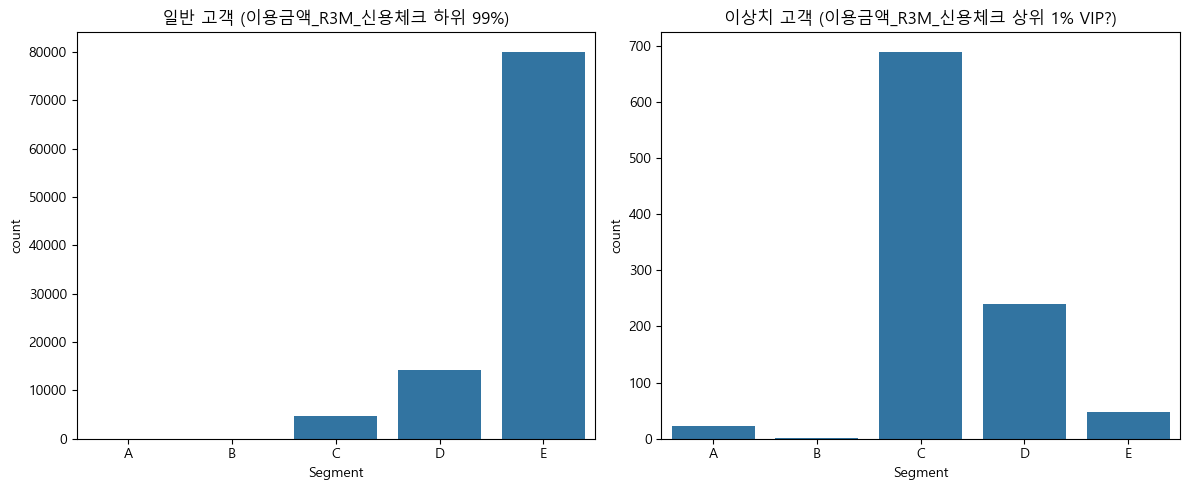


📢 [결과 해석 방법]
오른쪽 그래프(이상치 고객)의 분포를 보세요.
1. 특정 등급(예: A)에 몰려있다? -> 'VIP 정보'입니다. 지우지 말고 [로그 변환] 하세요.
2. 전체 등급에 골고루 퍼져있다? -> 큰 의미 없는 '노이즈'일 수 있습니다. [윈저라이징] 하세요.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq

# 파일 경로
file_path = r'C:\Users\CY2\github\DataScience\Credit Card\merged_train.parquet'

# 1. 데이터 샘플 로드 (10만 개)
parquet_file = pq.ParquetFile(file_path)
df = next(parquet_file.iter_batches(batch_size=100000)).to_pandas()

# 2. 전처리: Segment(Target)가 문자라면 숫자로 변환 (분석용)
# 만약 이미 숫자로 되어있다면 패스, 문자(A~E)라면 매핑
if df['Segment'].dtype == 'O': 
    mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4} # 예시
    # 실제 데이터에 맞게 매핑 필요. 여기서는 그대로 둡니다.

# 3. [검증 실험] "이용금액 이상치들은 어떤 등급(Segment)일까?"
# 분석할 컬럼 선택 (가장 의심스러운 '금액' 컬럼 하나 고르세요)
# 예: 이용금액 관련 컬럼 중 하나 (컬럼명은 describe로 확인한 것 중 하나)
target_col = [c for c in df.columns if '금액' in c and '이용' in c][0] 
print(f"🕵️‍♂️ 분석 대상 컬럼: {target_col}")

# (1) 이상치와 정상치 구분
# 상위 1%를 이상치(High Value)로 정의
threshold = df[target_col].quantile(0.99)
df['Is_Outlier'] = df[target_col] > threshold

# (2) 이상치인 사람들의 등급 분포 vs 정상인 사람들의 등급 분포 비교
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Segment', data=df[df['Is_Outlier'] == False], order=sorted(df['Segment'].unique()))
plt.title(f"일반 고객 ({target_col} 하위 99%)")

plt.subplot(1, 2, 2)
sns.countplot(x='Segment', data=df[df['Is_Outlier'] == True], order=sorted(df['Segment'].unique()))
plt.title(f"이상치 고객 ({target_col} 상위 1% VIP?)")

plt.tight_layout()
plt.show()

# (3) 결과 해석 가이드 출력
print("\n" + "="*50)
print("📢 [결과 해석 방법]")
print(f"오른쪽 그래프(이상치 고객)의 분포를 보세요.")
print(f"1. 특정 등급(예: A)에 몰려있다? -> 'VIP 정보'입니다. 지우지 말고 [로그 변환] 하세요.")
print(f"2. 전체 등급에 골고루 퍼져있다? -> 큰 의미 없는 '노이즈'일 수 있습니다. [윈저라이징] 하세요.")
print("="*50)

### 불균형 데이터니까 Accuracy 보다는 Recall에 집중해야겠다.

In [33]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import gc # Garbage Collector (메모리 해제용)

def analyze_financial_outliers_low_mem(file_path, segment_col='segment'):
    # 1. 처음부터 전체를 읽지 않고, 컬럼 목록만 먼저 확인
    # Parquet 파일은 메타데이터가 있어 컬럼 확인이 빠릅니다.
    temp_df = pd.read_parquet(file_path, columns=[]) 
    all_cols = pd.read_parquet(file_path).columns.tolist()
    
    # 세그먼트 데이터만 먼저 메모리에 로드
    segment_series = pd.read_parquet(file_path, columns=[segment_col])[segment_col]
    
    outlier_analysis = []
    
    print(f"--- 분석 시작 (메모리 절약 모드) ---")

    for col in all_cols:
        if col == segment_col:
            continue
            
        # 2. 한 번에 '하나의 컬럼'만 읽어옵니다. (메모리 보존 핵심)
        col_data = pd.read_parquet(file_path, columns=[col])[col]
        
        # 수치형 컬럼인지 확인
        if not np.issubdtype(col_data.dtype, np.number):
            del col_data
            continue

        # 3. 이상치 계산 (데이터 복사 최소화)
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 여부를 Boolean 타입으로 생성 (int64보다 메모리 적게 사용)
        is_outlier = (col_data < lower_bound) | (col_data > upper_bound)
        outlier_count = is_outlier.sum()

        if outlier_count > 0:
            # 4. 카이제곱 검정용 교차표 생성
            contingency_table = pd.crosstab(is_outlier, segment_series)
            
            try:
                chi2, p, _, _ = chi2_contingency(contingency_table)
                outlier_analysis.append({
                    'Column': col,
                    'Outlier_Count': outlier_count,
                    'Outlier_Ratio(%)': round((outlier_count / len(is_outlier)) * 100, 2),
                    'P-Value(Importance)': round(p, 4),
                    'Is_Significant': 'YES' if p < 0.05 else 'NO'
                })
            except:
                pass
        
        # 사용이 끝난 변수 명시적 삭제 및 메모리 정리
        del col_data
        del is_outlier
        gc.collect() 

    result_df = pd.DataFrame(outlier_analysis)
    return result_df.sort_values(by='P-Value(Importance)') if not result_df.empty else result_df

# 실행
file_path = r'C:\Users\CY2\github\DataScience\Credit Card\merged_train.parquet'
report = analyze_financial_outliers_low_mem(file_path, segment_col='segment')

print("\n[이상치 컬럼별 세그먼트 상관관계 분석 보고서]")
print(report)

ArrowInvalid: No match for FieldRef.Name(segment) in 기준년월: int64
ID: string
남녀구분코드: int64
연령: string
Segment: string
회원여부_이용가능: int64
회원여부_이용가능_CA: int64
회원여부_이용가능_카드론: int64
소지여부_신용: int64
소지카드수_유효_신용: int64
소지카드수_이용가능_신용: int64
입회일자_신용: int64
입회경과개월수_신용: int64
회원여부_연체: int64
이용거절여부_카드론: int64
동의여부_한도증액안내: int64
수신거부여부_TM: int64
수신거부여부_DM: int64
수신거부여부_메일: int64
수신거부여부_SMS: int64
가입통신회사코드: string
탈회횟수_누적: int64
최종탈회후경과월: int64
탈회횟수_발급6개월이내: int64
탈회횟수_발급1년이내: int64
거주시도명: string
직장시도명: string
마케팅동의여부: int64
유효카드수_신용체크: int64
유효카드수_신용: int64
유효카드수_신용_가족: int64
유효카드수_체크: int64
유효카드수_체크_가족: int64
이용가능카드수_신용체크: int64
이용가능카드수_신용: int64
이용가능카드수_신용_가족: int64
이용가능카드수_체크: int64
이용가능카드수_체크_가족: int64
이용카드수_신용체크: int64
이용카드수_신용: int64
이용카드수_신용_가족: int64
이용카드수_체크: int64
이용카드수_체크_가족: int64
이용금액_R3M_신용체크: int64
이용금액_R3M_신용: int64
이용금액_R3M_신용_가족: int64
이용금액_R3M_체크: int64
이용금액_R3M_체크_가족: int64
_1순위카드이용금액: int64
_1순위카드이용건수: int64
_1순위신용체크구분: string
_2순위카드이용금액: int64
_2순위카드이용건수: int64
_2순위신용체크구분: string
최종유효년월_신용_이용가능: double
최종유효년월_신용_이용: double
최종카드발급일자: double
보유여부_해외겸용_본인: int64
이용가능여부_해외겸용_본인: int64
이용여부_3M_해외겸용_본인: int64
보유여부_해외겸용_신용_본인: int64
이용가능여부_해외겸용_신용_본인: int64
이용여부_3M_해외겸용_신용_본인: int64
연회비발생카드수_B0M: string
연회비할인카드수_B0M: int64
기본연회비_B0M: int64
제휴연회비_B0M: int64
할인금액_기본연회비_B0M: int64
할인금액_제휴연회비_B0M: int64
청구금액_기본연회비_B0M: int64
청구금액_제휴연회비_B0M: int64
상품관련면제카드수_B0M: string
임직원면제카드수_B0M: string
우수회원면제카드수_B0M: string
기타면제카드수_B0M: string
카드신청건수: int64
Life_Stage: string
최종카드발급경과월: int64
최초한도금액: int64
카드이용한도금액: int64
CA한도금액: int64
일시상환론한도금액: int64
월상환론한도금액: int64
CA이자율_할인전: double
CL이자율_할인전: double
RV일시불이자율_할인전: double
RV현금서비스이자율_할인전: double
RV신청일자: double
RV약정청구율: double
RV최소결제비율: double
자발한도감액횟수_R12M: string
자발한도감액금액_R12M: int64
자발한도감액후경과월: int64
강제한도감액횟수_R12M: int64
강제한도감액금액_R12M: int64
강제한도감액후경과월: int64
한도증액횟수_R12M: string
한도증액금액_R12M: int64
한도증액후경과월: int64
상향가능한도금액: int64
상향가능CA한도금액: int64
카드론동의여부: string
월상환론상향가능한도금액: int64
RV전환가능여부: string
일시불ONLY전환가능여부: int64
카드이용한도금액_B1M: int64
카드이용한도금액_B2M: int64
특별한도보유여부_R3M: int64
연체감액여부_R3M: int64
한도심사요청건수: string
한도요청거절건수: int64
한도심사요청후경과월: int64
한도심사거절후경과월: int64
시장단기연체여부_R6M: int64
시장단기연체여부_R3M: int64
시장연체상환여부_R6M: int64
시장연체상환여부_R3M: int64
rv최초시작후경과일: int64
최종이용일자_기본: int64
최종이용일자_신판: int64
최종이용일자_CA: int64
최종이용일자_카드론: int64
최종이용일자_체크: int64
최종이용일자_일시불: int64
최종이용일자_할부: int64
이용건수_신용_B0M: int64
이용건수_신판_B0M: int64
이용건수_일시불_B0M: int64
이용건수_할부_B0M: int64
이용건수_할부_유이자_B0M: int64
이용건수_할부_무이자_B0M: int64
이용건수_부분무이자_B0M: int64
이용건수_CA_B0M: int64
이용건수_체크_B0M: int64
이용건수_카드론_B0M: int64
이용금액_일시불_B0M: int64
이용금액_할부_B0M: int64
이용금액_할부_유이자_B0M: int64
이용금액_할부_무이자_B0M: int64
이용금액_부분무이자_B0M: int64
이용금액_CA_B0M: int64
이용금액_체크_B0M: int64
이용금액_카드론_B0M: int64
이용후경과월_신용: int64
이용후경과월_신판: int64
이용후경과월_일시불: int64
이용후경과월_할부: int64
이용후경과월_할부_유이자: int64
이용후경과월_할부_무이자: int64
이용후경과월_부분무이자: int64
이용후경과월_CA: int64
이용후경과월_체크: int64
이용후경과월_카드론: int64
이용건수_신용_R12M: int64
이용건수_신판_R12M: int64
이용건수_일시불_R12M: int64
이용건수_할부_R12M: int64
이용건수_할부_유이자_R12M: int64
이용건수_할부_무이자_R12M: int64
이용건수_부분무이자_R12M: int64
이용건수_CA_R12M: int64
이용건수_체크_R12M: int64
이용건수_카드론_R12M: int64
이용금액_일시불_R12M: int64
이용금액_할부_R12M: int64
이용금액_할부_유이자_R12M: int64
이용금액_할부_무이자_R12M: int64
이용금액_부분무이자_R12M: int64
이용금액_CA_R12M: int64
이용금액_체크_R12M: int64
이용금액_카드론_R12M: int64
최대이용금액_일시불_R12M: int64
최대이용금액_할부_R12M: int64
최대이용금액_할부_유이자_R12M: int64
최대이용금액_할부_무이자_R12M: int64
최대이용금액_부분무이자_R12M: int64
최대이용금액_CA_R12M: int64
최대이용금액_체크_R12M: int64
최대이용금액_카드론_R12M: int64
이용개월수_신용_R12M: int64
이용개월수_신판_R12M: int64
이용개월수_일시불_R12M: int64
이용개월수_할부_R12M: int64
이용개월수_할부_유이자_R12M: int64
이용개월수_할부_무이자_R12M: int64
이용개월수_부분무이자_R12M: int64
이용개월수_CA_R12M: int64
이용개월수_체크_R12M: int64
이용개월수_카드론_R12M: int64
이용건수_신용_R6M: int64
이용건수_신판_R6M: int64
이용건수_일시불_R6M: int64
이용건수_할부_R6M: int64
이용건수_할부_유이자_R6M: int64
이용건수_할부_무이자_R6M: int64
이용건수_부분무이자_R6M: int64
이용건수_CA_R6M: int64
이용건수_체크_R6M: int64
이용건수_카드론_R6M: int64
이용금액_일시불_R6M: int64
이용금액_할부_R6M: int64
이용금액_할부_유이자_R6M: int64
이용금액_할부_무이자_R6M: int64
이용금액_부분무이자_R6M: int64
이용금액_CA_R6M: int64
이용금액_체크_R6M: int64
이용금액_카드론_R6M: int64
이용개월수_신용_R6M: int64
이용개월수_신판_R6M: int64
이용개월수_일시불_R6M: int64
이용개월수_할부_R6M: int64
이용개월수_할부_유이자_R6M: int64
이용개월수_할부_무이자_R6M: int64
이용개월수_부분무이자_R6M: int64
이용개월수_CA_R6M: int64
이용개월수_체크_R6M: int64
이용개월수_카드론_R6M: int64
이용건수_신용_R3M: int64
이용건수_신판_R3M: int64
이용건수_일시불_R3M: int64
이용건수_할부_R3M: int64
이용건수_할부_유이자_R3M: int64
이용건수_할부_무이자_R3M: int64
이용건수_부분무이자_R3M: int64
이용건수_CA_R3M: int64
이용건수_체크_R3M: int64
이용건수_카드론_R3M: int64
이용금액_일시불_R3M: int64
이용금액_할부_R3M: int64
이용금액_할부_유이자_R3M: int64
이용금액_할부_무이자_R3M: int64
이용금액_부분무이자_R3M: int64
이용금액_CA_R3M: int64
이용금액_체크_R3M: int64
이용금액_카드론_R3M: int64
이용개월수_신용_R3M: int64
이용개월수_신판_R3M: int64
이용개월수_일시불_R3M: int64
이용개월수_할부_R3M: int64
이용개월수_할부_유이자_R3M: int64
이용개월수_할부_무이자_R3M: int64
이용개월수_부분무이자_R3M: int64
이용개월수_CA_R3M: int64
이용개월수_체크_R3M: int64
이용개월수_카드론_R3M: int64
이용가맹점수: int64
이용금액_해외: int64
쇼핑_도소매_이용금액: int64
쇼핑_백화점_이용금액: int64
쇼핑_마트_이용금액: int64
쇼핑_슈퍼마켓_이용금액: int64
쇼핑_편의점_이용금액: int64
쇼핑_아울렛_이용금액: int64
쇼핑_온라인_이용금액: int64
쇼핑_기타_이용금액: int64
교통_주유이용금액: int64
교통_정비이용금액: int64
교통_통행료이용금액: int64
교통_버스지하철이용금액: int64
교통_택시이용금액: int64
교통_철도버스이용금액: int64
여유_운동이용금액: int64
여유_Pet이용금액: int64
여유_공연이용금액: int64
여유_공원이용금액: int64
여유_숙박이용금액: int64
여유_여행이용금액: int64
여유_항공이용금액: int64
여유_기타이용금액: int64
납부_통신비이용금액: int64
납부_관리비이용금액: int64
납부_렌탈료이용금액: int64
납부_가스전기료이용금액: int64
납부_보험료이용금액: int64
납부_유선방송이용금액: int64
납부_건강연금이용금액: int64
납부_기타이용금액: int64
_1순위업종: string
_1순위업종_이용금액: int64
_2순위업종: string
_2순위업종_이용금액: int64
_3순위업종: string
_3순위업종_이용금액: int64
_1순위쇼핑업종: string
_1순위쇼핑업종_이용금액: int64
_2순위쇼핑업종: string
_2순위쇼핑업종_이용금액: int64
_3순위쇼핑업종: string
_3순위쇼핑업종_이용금액: int64
_1순위교통업종: string
_1순위교통업종_이용금액: int64
_2순위교통업종: string
_2순위교통업종_이용금액: int64
_3순위교통업종: string
_3순위교통업종_이용금액: int64
_1순위여유업종: string
_1순위여유업종_이용금액: int64
_2순위여유업종: string
_2순위여유업종_이용금액: int64
_3순위여유업종: string
_3순위여유업종_이용금액: int64
_1순위납부업종: string
_1순위납부업종_이용금액: int64
_2순위납부업종: string
_2순위납부업종_이용금액: int64
_3순위납부업종: string
_3순위납부업종_이용금액: int64
할부건수_3M_R12M: int64
할부건수_6M_R12M: int64
할부건수_12M_R12M: int64
할부건수_14M_R12M: int64
할부금액_3M_R12M: int64
할부금액_6M_R12M: int64
할부금액_12M_R12M: int64
할부금액_14M_R12M: int64
할부건수_유이자_3M_R12M: int64
할부건수_유이자_6M_R12M: int64
할부건수_유이자_12M_R12M: int64
할부건수_유이자_14M_R12M: int64
할부금액_유이자_3M_R12M: int64
할부금액_유이자_6M_R12M: int64
할부금액_유이자_12M_R12M: int64
할부금액_유이자_14M_R12M: int64
할부건수_무이자_3M_R12M: int64
할부건수_무이자_6M_R12M: int64
할부건수_무이자_12M_R12M: int64
할부건수_무이자_14M_R12M: int64
할부금액_무이자_3M_R12M: int64
할부금액_무이자_6M_R12M: int64
할부금액_무이자_12M_R12M: int64
할부금액_무이자_14M_R12M: int64
할부건수_부분_3M_R12M: int64
할부건수_부분_6M_R12M: int64
할부건수_부분_12M_R12M: int64
할부건수_부분_14M_R12M: int64
할부금액_부분_3M_R12M: int64
할부금액_부분_6M_R12M: int64
할부금액_부분_12M_R12M: int64
할부금액_부분_14M_R12M: int64
RP건수_B0M: int64
RP금액_B0M: int64
RP유형건수_B0M: int64
RP건수_통신_B0M: int64
RP건수_아파트_B0M: int64
RP건수_제휴사서비스직접판매_B0M: int64
RP건수_렌탈_B0M: int64
RP건수_가스_B0M: int64
RP건수_전기_B0M: int64
RP건수_보험_B0M: int64
RP건수_학습비_B0M: int64
RP건수_유선방송_B0M: int64
RP건수_건강_B0M: int64
RP건수_교통_B0M: int64
RP후경과월: int64
RP후경과월_통신: int64
RP후경과월_아파트: int64
RP후경과월_제휴사서비스직접판매: int64
RP후경과월_렌탈: int64
RP후경과월_가스: int64
RP후경과월_전기: int64
RP후경과월_보험: int64
RP후경과월_학습비: int64
RP후경과월_유선방송: int64
RP후경과월_건강: int64
RP후경과월_교통: int64
증감_RP건수_전월: int64
증감_RP유형건수_전월: int64
증감_RP건수_통신_전월: int64
증감_RP건수_아파트_전월: int64
증감_RP건수_제휴사서비스직접판매_전월: int64
증감_RP건수_렌탈_전월: int64
증감_RP건수_가스_전월: int64
증감_RP건수_전기_전월: int64
증감_RP건수_보험_전월: int64
증감_RP건수_학습비_전월: int64
증감_RP건수_유선방송_전월: int64
증감_RP건수_건강_전월: int64
증감_RP건수_교통_전월: int64
최초카드론이용경과월: int64
최종카드론이용경과월: int64
카드론이용건수_누적: int64
카드론이용월수_누적: int64
카드론이용금액_누적: int64
최종카드론_금융상환방식코드: double
최종카드론_신청경로코드: string
최종카드론_대출이율: double
최종카드론_대출일자: double
최종카드론_대출월수: int64
최종카드론_거치개월수: int64
최종카드론_대출금액: int64
이용개월수_온라인_R6M: int64
이용개월수_오프라인_R6M: int64
이용금액_온라인_R6M: int64
이용금액_오프라인_R6M: int64
이용건수_온라인_R6M: int64
이용건수_오프라인_R6M: int64
이용금액_온라인_R3M: int64
이용금액_오프라인_R3M: int64
이용건수_온라인_R3M: int64
이용건수_오프라인_R3M: int64
이용금액_온라인_B0M: int64
이용금액_오프라인_B0M: int64
이용건수_온라인_B0M: int64
이용건수_오프라인_B0M: int64
이용개월수_페이_온라인_R6M: int64
이용개월수_페이_오프라인_R6M: int64
이용금액_페이_온라인_R6M: int64
이용금액_페이_오프라인_R6M: int64
이용건수_페이_온라인_R6M: int64
이용건수_페이_오프라인_R6M: int64
이용금액_페이_온라인_R3M: int64
이용금액_페이_오프라인_R3M: int64
이용건수_페이_온라인_R3M: int64
이용건수_페이_오프라인_R3M: int64
이용금액_페이_온라인_B0M: int64
이용금액_페이_오프라인_B0M: int64
이용건수_페이_온라인_B0M: int64
이용건수_페이_오프라인_B0M: int64
이용개월수_간편결제_R6M: int64
이용개월수_당사페이_R6M: int64
이용개월수_당사기타_R6M: int64
이용개월수_A페이_R6M: int64
이용개월수_B페이_R6M: int64
이용개월수_C페이_R6M: int64
이용개월수_D페이_R6M: int64
이용금액_간편결제_R6M: int64
이용금액_당사페이_R6M: int64
이용금액_당사기타_R6M: int64
이용금액_A페이_R6M: int64
이용금액_B페이_R6M: int64
이용금액_C페이_R6M: int64
이용금액_D페이_R6M: int64
이용건수_간편결제_R6M: int64
이용건수_당사페이_R6M: int64
이용건수_당사기타_R6M: int64
이용건수_A페이_R6M: int64
이용건수_B페이_R6M: int64
이용건수_C페이_R6M: int64
이용건수_D페이_R6M: int64
이용금액_간편결제_R3M: int64
이용금액_당사페이_R3M: int64
이용금액_당사기타_R3M: int64
이용금액_A페이_R3M: int64
이용금액_B페이_R3M: int64
이용금액_C페이_R3M: int64
이용금액_D페이_R3M: int64
이용건수_간편결제_R3M: int64
이용건수_당사페이_R3M: int64
이용건수_당사기타_R3M: int64
이용건수_A페이_R3M: int64
이용건수_B페이_R3M: int64
이용건수_C페이_R3M: int64
이용건수_D페이_R3M: int64
이용금액_간편결제_B0M: int64
이용금액_당사페이_B0M: int64
이용금액_당사기타_B0M: int64
이용금액_A페이_B0M: int64
이용금액_B페이_B0M: int64
이용금액_C페이_B0M: int64
이용금액_D페이_B0M: int64
이용건수_간편결제_B0M: int64
이용건수_당사페이_B0M: int64
이용건수_당사기타_B0M: int64
이용건수_A페이_B0M: int64
이용건수_B페이_B0M: int64
이용건수_C페이_B0M: int64
이용건수_D페이_B0M: int64
이용개월수_선결제_R6M: int64
이용횟수_선결제_R6M: int64
이용금액_선결제_R6M: int64
이용건수_선결제_R6M: int64
이용횟수_선결제_R3M: int64
이용금액_선결제_R3M: int64
이용건수_선결제_R3M: int64
이용횟수_선결제_B0M: int64
이용금액_선결제_B0M: int64
이용건수_선결제_B0M: int64
이용횟수_연체_R6M: int64
이용금액_연체_R6M: int64
이용횟수_연체_R3M: int64
이용금액_연체_R3M: int64
이용횟수_연체_B0M: int64
이용금액_연체_B0M: int64
이용개월수_전체_R6M: int64
이용개월수_전체_R3M: int64
이용개월수_결제일_R6M: int64
이용개월수_결제일_R3M: int64
가맹점매출금액_B1M: int64
가맹점매출금액_B2M: int64
정상청구원금_B0M: int64
선입금원금_B0M: int64
정상입금원금_B0M: int64
연체입금원금_B0M: int64
정상청구원금_B2M: int64
선입금원금_B2M: int64
정상입금원금_B2M: int64
연체입금원금_B2M: int64
정상청구원금_B5M: int64
선입금원금_B5M: int64
정상입금원금_B5M: int64
연체입금원금_B5M: int64
건수_할부전환_R6M: int64
건수_할부전환_R3M: int64
금액_할부전환_R6M: int64
금액_할부전환_R3M: int64
연속무실적개월수_기본_24M_카드: int64
연속유실적개월수_기본_24M_카드: int64
신청건수_ATM_CA_B0: int64
신청건수_ATM_CL_B0: int64
신청건수_ATM_CA_R6M: int64
신청건수_ATM_CL_R6M: int64
승인거절건수_B0M: int64
승인거절건수_한도초과_B0M: int64
승인거절건수_BL_B0M: int64
승인거절건수_입력오류_B0M: int64
승인거절건수_기타_B0M: int64
승인거절건수_R3M: int64
승인거절건수_한도초과_R3M: int64
승인거절건수_BL_R3M: int64
승인거절건수_입력오류_R3M: int64
승인거절건수_기타_R3M: int64
이용금액대: string
대표결제일: int64
대표결제방법코드: string
대표청구지고객주소구분코드: string
대표청구서수령지구분코드: string
청구서수령방법: string
청구서발송여부_B0: int64
청구서발송여부_R3M: int64
청구서발송여부_R6M: int64
청구금액_B0: int64
청구금액_R3M: int64
청구금액_R6M: int64
포인트_마일리지_건별_B0M: int64
포인트_마일리지_건별_R3M: int64
포인트_포인트_건별_B0M: int64
포인트_포인트_건별_R3M: int64
포인트_마일리지_월적립_B0M: int64
포인트_마일리지_월적립_R3M: int64
포인트_포인트_월적립_B0M: int64
포인트_포인트_월적립_R3M: int64
포인트_적립포인트_R12M: int64
포인트_적립포인트_R3M: int64
포인트_이용포인트_R12M: int64
포인트_이용포인트_R3M: int64
포인트_잔여포인트_B0M: int64
마일_적립포인트_R12M: int64
마일_적립포인트_R3M: int64
마일_이용포인트_R12M: int64
마일_이용포인트_R3M: int64
마일_잔여포인트_B0M: int64
할인건수_R3M: string
할인금액_R3M: int64
할인건수_B0M: string
할인금액_B0M: int64
할인금액_청구서_R3M: int64
할인금액_청구서_B0M: int64
상환개월수_결제일_R6M: int64
상환개월수_결제일_R3M: int64
선결제건수_R6M: int64
선결제건수_R3M: int64
연체건수_R6M: int64
연체건수_R3M: int64
혜택수혜금액_R3M: int64
포인트_마일리지_환산_B0M: int64
혜택수혜금액: int64
잔액_일시불_B0M: int64
잔액_할부_B0M: int64
잔액_현금서비스_B0M: int64
잔액_리볼빙일시불이월_B0M: int64
잔액_리볼빙CA이월_B0M: int64
잔액_카드론_B0M: int64
월중평잔_일시불_B0M: int64
월중평잔_할부_B0M: int64
월중평잔_CA_B0M: int64
카드론잔액_최종경과월: int64
연체일자_B0M: double
연체잔액_B0M: int64
연체잔액_일시불_B0M: int64
연체잔액_할부_B0M: int64
연체잔액_현금서비스_B0M: int64
연체잔액_카드론_B0M: int64
연체잔액_대환론_B0M: int64
잔액_현금서비스_B1M: int64
잔액_현금서비스_B2M: int64
잔액_카드론_B1M: int64
잔액_카드론_B2M: int64
잔액_카드론_B3M: int64
잔액_카드론_B4M: int64
잔액_카드론_B5M: int64
잔액_할부_B1M: int64
잔액_할부_B2M: int64
잔액_일시불_B1M: int64
잔액_일시불_B2M: int64
연체일수_B1M: int64
연체일수_B2M: int64
연체원금_B1M: int64
연체원금_B2M: int64
연체일수_최근: int64
연체원금_최근: int64
최종연체회차: int64
매각잔액_B1M: int64
최종연체개월수_R15M: int64
RV_평균잔액_R12M: int64
RV_최대잔액_R12M: int64
RV_평균잔액_R6M: int64
RV_최대잔액_R6M: int64
RV_평균잔액_R3M: int64
RV_최대잔액_R3M: int64
RV잔액이월횟수_R6M: int64
RV잔액이월횟수_R3M: int64
잔액_할부_유이자_B0M: int64
잔액_할부_무이자_B0M: int64
잔액_할부_해외_B0M: int64
연체잔액_일시불_해외_B0M: int64
연체잔액_RV일시불_B0M: int64
연체잔액_RV일시불_해외_B0M: int64
연체잔액_할부_해외_B0M: int64
연체잔액_CA_B0M: int64
연체잔액_CA_해외_B0M: int64
월중평잔: int64
월중평잔_일시불: int64
월중평잔_RV일시불: int64
월중평잔_할부: int64
월중평잔_CA: int64
월중평잔_카드론: int64
평잔_3M: int64
평잔_일시불_3M: int64
평잔_일시불_해외_3M: int64
평잔_RV일시불_3M: int64
평잔_RV일시불_해외_3M: int64
평잔_할부_3M: int64
평잔_할부_해외_3M: int64
평잔_CA_3M: int64
평잔_CA_해외_3M: int64
평잔_카드론_3M: int64
평잔_6M: int64
평잔_일시불_6M: int64
평잔_일시불_해외_6M: int64
평잔_RV일시불_6M: int64
평잔_RV일시불_해외_6M: int64
평잔_할부_6M: int64
평잔_할부_해외_6M: int64
평잔_CA_6M: int64
평잔_CA_해외_6M: int64
평잔_카드론_6M: int64
인입횟수_ARS_R6M: string
이용메뉴건수_ARS_R6M: string
인입일수_ARS_R6M: int64
인입월수_ARS_R6M: int64
인입후경과월_ARS: int64
인입횟수_ARS_B0M: int64
이용메뉴건수_ARS_B0M: int64
인입일수_ARS_B0M: int64
방문횟수_PC_R6M: string
방문일수_PC_R6M: string
방문월수_PC_R6M: int64
방문후경과월_PC_R6M: int64
방문횟수_앱_R6M: string
방문일수_앱_R6M: int64
방문월수_앱_R6M: int64
방문후경과월_앱_R6M: int64
방문횟수_모바일웹_R6M: int64
방문일수_모바일웹_R6M: int64
방문월수_모바일웹_R6M: int64
방문후경과월_모바일웹_R6M: int64
방문횟수_PC_B0M: int64
방문일수_PC_B0M: int64
방문횟수_앱_B0M: int64
방문일수_앱_B0M: int64
방문횟수_모바일웹_B0M: int64
방문일수_모바일웹_B0M: int64
인입횟수_IB_R6M: int64
인입횟수_금융_IB_R6M: int64
인입일수_IB_R6M: int64
인입월수_IB_R6M: int64
이용메뉴건수_IB_R6M: int64
인입후경과월_IB_R6M: int64
인입횟수_IB_B0M: int64
인입일수_IB_B0M: int64
이용메뉴건수_IB_B0M: int64
인입불만횟수_IB_R6M: int64
인입불만일수_IB_R6M: int64
인입불만월수_IB_R6M: int64
인입불만후경과월_IB_R6M: int64
인입불만횟수_IB_B0M: int64
인입불만일수_IB_B0M: int64
상담건수_B0M: int64
IB문의건수_사용승인내역_B0M: int64
IB문의건수_한도_B0M: int64
IB문의건수_선결제_B0M: int64
IB문의건수_결제_B0M: int64
IB문의건수_할부_B0M: int64
IB문의건수_정보변경_B0M: int64
IB문의건수_결제일변경_B0M: int64
IB문의건수_명세서_B0M: int64
IB문의건수_비밀번호_B0M: int64
IB문의건수_SMS_B0M: int64
IB문의건수_APP_B0M: int64
IB문의건수_부대서비스_B0M: int64
IB문의건수_포인트_B0M: int64
IB문의건수_카드발급_B0M: int64
IB문의건수_BL_B0M: int64
IB문의건수_분실도난_B0M: int64
IB문의건수_CA_B0M: int64
IB문의건수_CL_RV_B0M: int64
IB문의건수_CS_B0M: int64
IB상담건수_VOC_B0M: int64
IB상담건수_VOC민원_B0M: int64
IB상담건수_VOC불만_B0M: int64
IB상담건수_금감원_B0M: int64
상담건수_R6M: int64
IB문의건수_사용승인내역_R6M: int64
IB문의건수_한도_R6M: int64
IB문의건수_선결제_R6M: int64
IB문의건수_결제_R6M: int64
IB문의건수_할부_R6M: int64
IB문의건수_정보변경_R6M: int64
IB문의건수_결제일변경_R6M: int64
IB문의건수_명세서_R6M: int64
IB문의건수_비밀번호_R6M: int64
IB문의건수_SMS_R6M: int64
IB문의건수_APP_R6M: int64
IB문의건수_부대서비스_R6M: int64
IB문의건수_포인트_R6M: int64
IB문의건수_카드발급_R6M: int64
IB문의건수_BL_R6M: int64
IB문의건수_분실도난_R6M: int64
IB문의건수_CA_R6M: int64
IB문의건수_CL_RV_R6M: int64
IB문의건수_CS_R6M: int64
IB상담건수_VOC_R6M: int64
IB상담건수_VOC민원_R6M: int64
IB상담건수_VOC불만_R6M: int64
IB상담건수_금감원_R6M: int64
불만제기건수_B0M: int64
불만제기건수_R12M: int64
불만제기후경과월_R12M: int64
당사PAY_방문횟수_B0M: int64
당사PAY_방문횟수_R6M: int64
당사PAY_방문월수_R6M: int64
당사멤버쉽_방문횟수_B0M: int64
당사멤버쉽_방문횟수_R6M: int64
당사멤버쉽_방문월수_R6M: int64
OS구분코드: string
홈페이지_금융건수_R6M: int64
홈페이지_선결제건수_R6M: int64
홈페이지_금융건수_R3M: int64
홈페이지_선결제건수_R3M: int64
컨택건수_카드론_TM_B0M: int64
컨택건수_리볼빙_TM_B0M: int64
컨택건수_CA_TM_B0M: int64
컨택건수_이용유도_TM_B0M: int64
컨택건수_신용발급_TM_B0M: int64
컨택건수_부대서비스_TM_B0M: int64
컨택건수_포인트소진_TM_B0M: int64
컨택건수_보험_TM_B0M: int64
컨택건수_카드론_LMS_B0M: int64
컨택건수_CA_LMS_B0M: int64
컨택건수_리볼빙_LMS_B0M: int64
컨택건수_이용유도_LMS_B0M: int64
컨택건수_카드론_EM_B0M: int64
컨택건수_CA_EM_B0M: int64
컨택건수_리볼빙_EM_B0M: int64
컨택건수_이용유도_EM_B0M: int64
컨택건수_카드론_청구서_B0M: int64
컨택건수_CA_청구서_B0M: int64
컨택건수_리볼빙_청구서_B0M: int64
컨택건수_이용유도_청구서_B0M: int64
컨택건수_카드론_인터넷_B0M: int64
컨택건수_CA_인터넷_B0M: int64
컨택건수_리볼빙_인터넷_B0M: int64
컨택건수_이용유도_인터넷_B0M: int64
컨택건수_카드론_당사앱_B0M: int64
컨택건수_CA_당사앱_B0M: int64
컨택건수_리볼빙_당사앱_B0M: int64
컨택건수_이용유도_당사앱_B0M: int64
컨택건수_카드론_TM_R6M: int64
컨택건수_CA_TM_R6M: int64
컨택건수_리볼빙_TM_R6M: int64
컨택건수_이용유도_TM_R6M: int64
컨택건수_신용발급_TM_R6M: int64
컨택건수_부대서비스_TM_R6M: int64
컨택건수_포인트소진_TM_R6M: int64
컨택건수_보험_TM_R6M: int64
컨택건수_카드론_LMS_R6M: int64
컨택건수_CA_LMS_R6M: int64
컨택건수_리볼빙_LMS_R6M: int64
컨택건수_이용유도_LMS_R6M: int64
컨택건수_카드론_EM_R6M: int64
컨택건수_CA_EM_R6M: int64
컨택건수_리볼빙_EM_R6M: int64
컨택건수_이용유도_EM_R6M: int64
컨택건수_카드론_청구서_R6M: int64
컨택건수_CA_청구서_R6M: int64
컨택건수_리볼빙_청구서_R6M: int64
컨택건수_이용유도_청구서_R6M: int64
컨택건수_카드론_인터넷_R6M: int64
컨택건수_CA_인터넷_R6M: int64
컨택건수_리볼빙_인터넷_R6M: int64
컨택건수_이용유도_인터넷_R6M: int64
컨택건수_카드론_당사앱_R6M: int64
컨택건수_CA_당사앱_R6M: int64
컨택건수_리볼빙_당사앱_R6M: int64
컨택건수_이용유도_당사앱_R6M: int64
컨택건수_채권_B0M: int64
컨택건수_FDS_B0M: int64
컨택건수_채권_R6M: int64
컨택건수_FDS_R6M: int64
캠페인접촉건수_R12M: string
캠페인접촉일수_R12M: string
증감율_이용건수_신용_전월: double
증감율_이용건수_신판_전월: double
증감율_이용건수_일시불_전월: double
증감율_이용건수_할부_전월: double
증감율_이용건수_CA_전월: double
증감율_이용건수_체크_전월: double
증감율_이용건수_카드론_전월: double
증감율_이용금액_신용_전월: double
증감율_이용금액_신판_전월: double
증감율_이용금액_일시불_전월: double
증감율_이용금액_할부_전월: double
증감율_이용금액_CA_전월: double
증감율_이용금액_체크_전월: double
증감율_이용금액_카드론_전월: double
증감율_이용건수_신용_분기: double
증감율_이용건수_신판_분기: double
증감율_이용건수_일시불_분기: double
증감율_이용건수_할부_분기: double
증감율_이용건수_CA_분기: double
증감율_이용건수_체크_분기: double
증감율_이용건수_카드론_분기: double
증감율_이용금액_신용_분기: double
증감율_이용금액_신판_분기: double
증감율_이용금액_일시불_분기: double
증감율_이용금액_할부_분기: double
증감율_이용금액_CA_분기: double
증감율_이용금액_체크_분기: double
증감율_이용금액_카드론_분기: double
잔액_신판평균한도소진율_r6m: double
잔액_신판최대한도소진율_r6m: double
잔액_신판평균한도소진율_r3m: double
잔액_신판최대한도소진율_r3m: double
잔액_신판ca평균한도소진율_r6m: double
잔액_신판ca최대한도소진율_r6m: double
잔액_신판ca평균한도소진율_r3m: double
잔액_신판ca최대한도소진율_r3m: double
변동률_일시불평잔: double
변동률_RV일시불평잔: double
변동률_할부평잔: double
변동률_CA평잔: double
변동률_RVCA평잔: double
변동률_카드론평잔: double
변동률_잔액_B1M: double
변동률_잔액_일시불_B1M: double
변동률_잔액_CA_B1M: double
혜택수혜율_R3M: double
혜택수혜율_B0M: double
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string